In [1]:
import datetime as dt
import pandas as pd
import  plotly.express as px 
import plotly.graph_objects as go

#Read US Covid deaths abd filter LA county 
US_Deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
US_Deaths_df = pd.read_csv(US_Deaths_url, error_bad_lines=True)
US_Deaths_df=US_Deaths_df.drop(columns=['UID','iso2','iso3','code3','Admin2', 'Country_Region','Lat','Long_','Combined_Key'])
US_Deaths_df=US_Deaths_df.dropna(subset=['FIPS'])
US_Deaths_df=US_Deaths_df.melt(id_vars=["FIPS","Population","Province_State"], 
        var_name="Date", 
        value_name="Value")

#Read US Covid cases
Confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
US_Cases_df = pd.read_csv(Confirmed_url, error_bad_lines=True)
US_Cases_df=US_Cases_df.drop(columns=['UID','iso2','iso3','code3','Admin2', 'Province_State', 'Country_Region','Lat','Long_','Combined_Key'])
US_Cases_df=US_Cases_df.dropna(subset=['FIPS'])
US_Cases_df=US_Cases_df.melt(id_vars=['FIPS'], 
        var_name="Date", 
        value_name="Value")


US_Deaths_df.iloc[:, 3] = pd.to_datetime(US_Deaths_df.iloc[:, 3])
US_Deaths_df.iloc[:, 3]  = (US_Deaths_df.iloc[:, 3]  - US_Deaths_df['Date'].iloc[0]).dt.days
US_Deaths_df = US_Deaths_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Deaths' })

#US_Deaths_df['Weekly_Deaths'] = US_Deaths_df.groupby(['FIPS', 'Week'])['Cumulative_Deaths'].transform(lambda x: (x.iat[-1] - x.iat[0]))
US_Deaths_df['Weekly_Deaths'] = 0
US_Deaths_df['Weekly_Deaths_Per'] = 0.0
US_Deaths_df['Past_Week_Cumulative_Deaths'] = 0
US_Deaths_df = US_Deaths_df.reset_index()
US_Deaths_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Deaths_df['Cumulative_Deaths'].to_numpy()
fipsArray = US_Deaths_df['FIPS'].to_numpy()
i = 0
j = 0
FIPS = 0.0
for index, row in US_Deaths_df.iterrows():
  countyFIPS = row['FIPS']
  if FIPS == countyFIPS: 
    if j > 6 and fipsArray[i-7] == countyFIPS :
        previous_cum_deaths = cdArray[i-7]
        weekly_deaths = row['Cumulative_Deaths'] - previous_cum_deaths
        US_Deaths_df.at[index,'Weekly_Deaths'] =  weekly_deaths
        if previous_cum_deaths  == 0:
          previous_cum_deaths = 1
        US_Deaths_df.at[index, 'Past_Week_Cumulative_Deaths'] = previous_cum_deaths
        US_Deaths_df.at[index, 'Weekly_Deaths_Per'] = (weekly_deaths  * 100) / (previous_cum_deaths * 1.0)
  else:
    FIPS = countyFIPS
    j = 0 
    US_Deaths_df.at[index,'Weekly_Deaths'] = 0
  i = i + 1
  j = j + 1

US_Cases_df.iloc[:, 1] = pd.to_datetime(US_Cases_df.iloc[:, 1])
US_Cases_df.iloc[:, 1]  = (US_Cases_df.iloc[:, 1]  - US_Cases_df['Date'].iloc[0]).dt.days
US_Cases_df = US_Cases_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Cases'})
US_Cases_df['Weekly_Cases'] = 0
US_Cases_df['Weekly_Cases_Per'] = 0.0
US_Cases_df = US_Cases_df.reset_index()
US_Cases_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Cases_df['Cumulative_Cases'].to_numpy()
fipsArray = US_Cases_df['FIPS'].to_numpy()
i = 0
j = 0
for index, row in US_Cases_df.iterrows():
  countyFIPS = row['FIPS']
  if FIPS == countyFIPS: 
    if j > 6 and fipsArray[i-7] == countyFIPS :
        previous_cum_cases = cdArray[i-7]
        weekly_cases = row['Cumulative_Cases'] - previous_cum_cases
        US_Cases_df.at[index,'Weekly_Cases'] =  weekly_cases
        if previous_cum_cases  == 0:
          previous_cum_cases = 1
        US_Cases_df.at[index, 'Weekly_Cases_Per'] = (weekly_cases * 100.0) / (previous_cum_cases * 1.0)
  else:
    FIPS = countyFIPS
    j = 0
    US_Cases_df.at[index,'Weekly_Cases'] = 0
  i = i + 1
  j = j + 1
 

In [2]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [3]:
#load state tests data to combine with cases and deaths
#data is not available for all days, populate zero for missing ones
from datetime import timedelta, date

state_codes = pd.read_csv('https://docs.google.com/spreadsheets/d/1DAqxIYJdagFN85ncoTQO-CbpJLQECvZWt6qwNMQZUkk/export?format=csv')
start_date = date(2020, 1, 22)
end_date = date.today()

state_codes_date_df = pd.DataFrame({'Date': pd.Series([], dtype='str'),
                   'Code': pd.Series([], dtype='str'),
                   'State': pd.Series([], dtype='str')})
for single_date in daterange(start_date, end_date):
  for index, row in state_codes.iterrows():
    state_codes_date_df = state_codes_date_df.append({'Date': single_date.strftime("%Y%m%d"), 'Code' : row["Code"], 'State' : row["State"]}, ignore_index=True)
state_tests = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")
convert_dict = {'date': str} 
state_tests = state_tests.astype(convert_dict)
state_tests_df = state_codes_date_df.merge(state_tests[['date','state','positive', 'negative']],how='left', left_on=['Date', 'Code'], right_on=['date', 'state'])
state_tests_df.sort_values(['Date','State'], inplace=True)
state_tests_df.iloc[:, 0] = pd.to_datetime(state_tests_df.iloc[:, 0],format="%Y%m%d")
state_tests_df.iloc[:, 0]  = (state_tests_df.iloc[:, 0] - state_tests_df['Date'].iloc[0]).dt.days
state_tests_df = state_tests_df.rename(columns={'Date': 'Days'})
state_tests_df['Cumulative_Tests'] = state_tests_df['positive'] + state_tests_df ['negative']
state_tests_df = state_tests_df.drop(columns=['date', 'state', 'positive', 'negative'])
state_tests_df.fillna(0, inplace=True)

In [4]:
#Read county variates dataset and combine with FIPS, race, icu_beds dataset
county_covariates= pd.read_csv('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv').dropna(subset=['FIPS'])
county_covariates.FIPS = county_covariates.FIPS.astype('int64')
county_covariates=county_covariates.set_index('FIPS')
age_race_df = pd.read_csv('https://docs.google.com/spreadsheets/d/12GIRONjeNHeKFb3EKpo5r-VvdsnTwwe0iOtKBsnZVM0/export?format=csv')
county_icu_beds= pd.read_csv('https://docs.google.com/spreadsheets/d/13iUBUwRcE91_x9FhsF8Ugcb0_tFauWJF2Z-PSkERDlU/export?format=csv')
FIPS = pd.read_csv('https://docs.google.com/spreadsheets/d/1jUwRaTSJ__3Wp60cZLLox5u55mJTZrShtjEK4d7xTEY/export?format=csv')
covariates = age_race_df.merge(county_covariates, how='inner', left_on=["fips"], right_on=['FIPS'])
covariates = covariates.drop(['STNAME', 'County', 'Unnamed: 0','State', 'Area_Name'], axis=1)
covariates = covariates.merge(county_icu_beds, how='inner', left_on=["fips"], right_on=['fips'])
covariates = covariates.drop(['County','State'], axis=1)
#dropping full NaN counties
covariates = covariates[covariates['Jul Temp Max / F'].notnull()]
#merge with US FIPS and makue  sure FIPS are only in the US
US_Deaths_df = US_Deaths_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
US_Cases_df = US_Cases_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
list(covariates.columns) 
covariates = covariates.dropna(axis='columns')
list(covariates.columns) 

covariates=covariates[['fips',
 'TOT_POP',
 '0-9',
 '0-9 y/o % of total pop',
 '10-19',
 '10-19 y/o % of total pop',
 '20-29',
 '20-29 y/o % of total pop',
 '30-39',
 '30-39 y/o % of total pop',
 '40-49',
 '40-49 y/o % of total pop',
 '50-59',
 '50-59 y/o % of total pop',
 '60-69',
 '60-69 y/o % of total pop',
 '70-79',
 '70-79 y/o % of total pop',
 '80+',
 '80+ y/o % of total pop',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races',
 'POP_ESTIMATE_2018',
 'N_POP_CHG_2018',
 'GQ_ESTIMATES_2018',
 'R_birth_2018',
 'R_death_2018',
 'R_NATURAL_INC_2018',
 'R_INTERNATIONAL_MIG_2018',
 'R_DOMESTIC_MIG_2018',
 'R_NET_MIG_2018',
 'Less than a high school diploma 2014-18',
 'High school diploma only 2014-18',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or higher 2014-18",
 'Percent of adults with less than a high school diploma 2014-18',
 'Percent of adults with a high school diploma only 2014-18',
 "Percent of adults completing some college or associate's degree 2014-18",
 "Percent of adults with a bachelor's degree or higher 2014-18",
 'POVALL_2018',
 'PCTPOVALL_2018',
 'PCTPOV017_2018',
 'PCTPOV517_2018',
 'MEDHHINC_2018',
 'CI90LBINC_2018',
 'CI90UBINC_2018',
 'Civilian_labor_force_2018',
 'Employed_2018',
 'Unemployed_2018',
 'Unemployment_rate_2018',
 'Median_Household_Income_2018',
 'Med_HH_Income_Percent_of_State_Total_2018',
 'Jan Precipitation / inch',
 'Feb Precipitation / inch',
 'Mar Precipitation / inch',
 'Apr Precipitation / inch',
 'May Precipitation / inch',
 'Jun Precipitation / inch',
 'Jul Precipitation / inch',
 'Jan Temp AVG / F',
 'Feb Temp AVG / F',
 'Mar Temp AVG / F',
 'Apr Temp AVG / F',
 'May Temp AVG / F',
 'Jun Temp AVG / F',
 'Jul Temp AVG / F',
 'Active Physicians per 100000 Population 2018 (AAMC)',
 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active General Surgeons per 100000 Population 2018 (AAMC)',
 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)',
 'Total nurse practitioners (2019)',
 'Total physician assistants (2019)',
 'Total Hospitals (2019)',
 'Internal Medicine Primary Care (2019)',
 'Family Medicine/General Practice Primary Care (2019)',
 'Total Specialist Physicians (2019)',
 'ICU Beds_x',
 'Total Population',
 'Population Aged 60+',
 'Percent of Population Aged 60+']]
 
#print(covariates)

In [5]:
#build prior - 1 ,2 ,3 week(s) cases and deaths as features
US_Cases_Prior_df = US_Cases_df.copy() 
US_Cases_Prior_df["Days"] = US_Cases_Prior_df["Days"] + 7
US_Cases_Prior_df.rename(columns = {'Weekly_Cases_Per':'One_Week_Prior_Weekly_Cases_Per', 'Weekly_Cases':'One_Week_Prior_Weekly_Cases'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_df.merge(US_Cases_Prior_df[['One_Week_Prior_Weekly_Cases_Per', 'One_Week_Prior_Weekly_Cases', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Cases_Prior_df = US_Cases_df.copy() 
US_Cases_Prior_df["Days"] = US_Cases_Prior_df["Days"] + 14
US_Cases_Prior_df.rename(columns = {'Weekly_Cases_Per':'Two_Week_Prior_Weekly_Cases_Per', 'Weekly_Cases':'Two_Week_Prior_Weekly_Cases'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Cases_Prior_df[['Two_Week_Prior_Weekly_Cases_Per', 'Two_Week_Prior_Weekly_Cases', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Cases_Prior_df = US_Cases_df.copy() 
US_Cases_Prior_df["Days"] = US_Cases_Prior_df["Days"] + 21
US_Cases_Prior_df.rename(columns = {'Weekly_Cases_Per':'Three_Week_Prior_Weekly_Cases_Per', 'Weekly_Cases':'Three_Week_Prior_Weekly_Cases'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Cases_Prior_df[['Three_Week_Prior_Weekly_Cases_Per', 'Three_Week_Prior_Weekly_Cases', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])

US_Deaths_Prior_df = US_Deaths_df.copy()
US_Deaths_Prior_df["Days"] = US_Deaths_Prior_df["Days"] + 7
US_Deaths_Prior_df.rename(columns = {'Weekly_Deaths_Per':'One_Week_Prior_Weekly_Deaths_Per', 'Weekly_Deaths':'One_Week_Prior_Weekly_Deaths'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Deaths_Prior_df[['One_Week_Prior_Weekly_Deaths_Per', 'One_Week_Prior_Weekly_Deaths', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Deaths_Prior_df = US_Deaths_df.copy()
US_Deaths_Prior_df["Days"] = US_Deaths_Prior_df["Days"] + 14
US_Deaths_Prior_df.rename(columns = {'Weekly_Deaths_Per':'Two_Week_Prior_Weekly_Deaths_Per', 'Weekly_Deaths':'Two_Week_Prior_Weekly_Deaths'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Deaths_Prior_df[['Two_Week_Prior_Weekly_Deaths_Per', 'Two_Week_Prior_Weekly_Deaths', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Deaths_Prior_df = US_Deaths_df.copy()
US_Deaths_Prior_df["Days"] = US_Deaths_Prior_df["Days"] + 21
US_Deaths_Prior_df.rename(columns = {'Weekly_Deaths_Per':'Three_Week_Prior_Weekly_Deaths_Per', 'Weekly_Deaths':'Three_Week_Prior_Weekly_Deaths'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Deaths_Prior_df[['Three_Week_Prior_Weekly_Deaths_Per', 'Three_Week_Prior_Weekly_Deaths', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])


In [6]:

US_Deaths_Cases_df = US_Deaths_Cases_df.merge(state_tests_df, how='inner', left_on=['Province_State', "Days"], right_on=['State', 'Days'])
covariates_merged = covariates.merge(US_Deaths_Cases_df[['Cumulative_Tests',
                                                        'Three_Week_Prior_Weekly_Cases_Per',
                                                        'Three_Week_Prior_Weekly_Cases',
                                                        'Two_Week_Prior_Weekly_Cases_Per',
                                                        'Two_Week_Prior_Weekly_Cases',
                                                        'One_Week_Prior_Weekly_Cases_Per',
                                                        'One_Week_Prior_Weekly_Cases',
                                                        'Three_Week_Prior_Weekly_Deaths_Per',
                                                        'Three_Week_Prior_Weekly_Deaths',
                                                        'Two_Week_Prior_Weekly_Deaths_Per',
                                                        'Two_Week_Prior_Weekly_Deaths',
                                                        'One_Week_Prior_Weekly_Deaths_Per',
                                                        'One_Week_Prior_Weekly_Deaths',
                                                         'FIPS', 'Days']], how='inner', left_on=["fips"], right_on=['FIPS'])
#dropping NaN columns
covariate_merged = covariates_merged.dropna(axis='columns')
US_Deaths_Cases_df =  US_Deaths_Cases_df.dropna(axis='columns')
fips_state=age_race_df[['STNAME','fips']]
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(fips_state, how='inner', left_on=["FIPS"], right_on=['fips'])
US_Deaths_Cases_df = US_Deaths_Cases_df.drop(columns=['index'])
#pd.set_option('display.max_rows', None)
#corr=covariate_merged.corr()
#print(corr[['Cumulative_Deaths','Daily_Deaths']])

In [9]:
US_Deaths_Cases_df[(US_Deaths_Cases_df['FIPS'] == 4015.0) & (US_Deaths_Cases_df['Days'] > 120)]

129       33.333333
130       33.333333
132       33.333333
133       66.666667
283        0.000000
            ...    
482461     0.000000
482611     0.000000
482612     0.000000
482614     0.000000
482615     0.000000
Name: Weekly_Deaths_Per, Length: 12536, dtype: float64

In [24]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore", category=ConvergenceWarning)
covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")

min_day=US_Deaths_Cases_df['Days'].min()
max_day=US_Deaths_Cases_df['Days'].max()
countyFIPS = US_Deaths_Cases_df["FIPS"].unique()

num_weeks=int((max_day-min_day)/7)
print("number of weeks : " , num_weeks)
#prediction_days_arr = [7,14,21,28]
#prediction_days = 7   # one week  train , tune and forecast
prediction_days = 14 # two weks train , tune and forecast
#prediction_days = 21 # three weks train , tune and forecast
#prediction_days = 28 # four weeks train , tune and forecast
day_offset=68
best_fit_scores = pd.DataFrame(columns=["Week Duration", "Best_Score", "Predict_R2_Score"])
predicted_df_all_days = pd.DataFrame(columns=['State','FIPS', 'Forecast_Day','Days','Predicted_Weekly_Deaths' 'Predicted_Cumulative_Deaths'])
#i = 0
#iteration = 0 
index = 0
#tune_forecast_rscores = pd.DataFrame( columns=['week', 'tune_alpha', 'tune_max_r2_score', 'forecast_r2_score'])
#weekly_alpha_rscores = pd.DataFrame( columns=['week', 'alpha', 'r2_score'])
#predict_week_rscores = pd.DataFrame( columns=['week', 'r2_score'])

train_start_week_day = day_offset
train_end_week_day = train_start_week_day + prediction_days
tune_start_week_day = train_end_week_day
tune_end_week_day = train_end_week_day + prediction_days
predict_start_week_day = train_end_week_day 
predict_end_week_day = predict_start_week_day + prediction_days
xgb = xgb.XGBRegressor()
  

for week_num in range(num_weeks):
    if train_end_week_day > max_day:
        break
    print("train:", train_start_week_day ,":", train_end_week_day, 
        " predict:" , predict_start_week_day, ":",  predict_end_week_day,
        " predict start date: ",  (covid_start_date + timedelta(days=predict_start_week_day)).date(),
        " predict end date: ",  (covid_start_date + timedelta(days=predict_end_week_day)).date())
    print 
    #print ("training week number: " , week_num+1)
    #********************TRAIN MODEL ************************ 
    #train with all coutnies variates for one  week  and predict for LA county cumulative deaths
    train_week = pd.Series(range(train_start_week_day,train_end_week_day))
    #print ("training week series :" , train_week.array)
    covariates_train_week = covariates_merged.loc[(covariates_merged['Days'].isin(train_week))] 
    US_Weekly_Deaths = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(train_week))].iloc[:, 5]  
    if len(US_Weekly_Deaths) == 0:
        continue
    alphas = [.0001,0.001, 0.01, 0.1]

    #train and predict the future week for LA County
    tune_week = pd.Series(range(tune_start_week_day, tune_end_week_day ))
    #print ("tune next week series :" , tune_week.array)

    alpha_with_max_r2score = -1
    max_r2score = -10
    best_reg = None

    X_train = covariates_train_week
    Y_train = US_Weekly_Deaths
    #reg = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
    parameters = {
          'objective':['reg:squarederror'],
          'learning_rate': [0.01, 0.1, 0.2, 0.3], #so called `eta` value
          'max_depth': [3],
          'min_child_weight': [1,2],
          'subsample': [0.8],
          'colsample_bytree' : [0.8],
          'n_estimators': [100,200]}
    xgb_grid = GridSearchCV(xgb,
                    parameters,
                    cv = 2,
                    n_jobs = 5,
                    scoring = 'r2',
                    verbose=True)

    xgb_grid.fit(X_train,Y_train)


    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)

    predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
    #print ("predicting next week series :" , predict_week.array)
  
    X_predict_week = covariates_merged.loc[(covariates_merged['Days'].isin(predict_week))]
    predict_week_df = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(predict_week))]
    Y_actual_predict_week = predict_week_df.iloc[:,5]
    #best_reg.fit(X_tune_week, Y_actual_tune_week)
    Y_predict_week = xgb_grid.best_estimator_.predict(X_predict_week)
    predict_score = r2_score(Y_actual_predict_week, Y_predict_week)
    print(week_num , ":", predict_score)
  
    predicted_df = pd.DataFrame(columns=['State','FIPS', 'Forecast_Day','Days','Predicted_Weekly_Deaths','Predicted_Cumulative_Deaths'])
    predicted_df["State"] = predict_week_df["STNAME"]
    predicted_df["FIPS"] = predict_week_df["FIPS"]
    predicted_df["Days"] = predict_week_df["Days"]
    predicted_df["Forecast_Day"] =  (covid_start_date + timedelta(days=(predict_start_week_day-1))).strftime("%Y-%m-%d")
    predicted_df["Predicted_Weekly_Deaths"] = Y_predict_week
    predicted_df["Predicted_Cumulative_Deaths"] = predicted_df["Predicted_Weekly_Deaths"]  + predict_week_df["Past_Week_Cumulative_Deaths"]
    best_fit_scores.loc[index] = [week_num,  xgb_grid.best_score_,  predict_score]
    
    pwcdArray = predicted_df["Predicted_Cumulative_Deaths"].to_numpy()
    fipsArray = predicted_df['FIPS'].to_numpy()
    j = 0
    i = 0 
    FIPS = 0.0
    for index, row in predicted_df.iterrows():
        countyFIPS = row['FIPS']
        if  FIPS == countyFIPS:
            if (j > 6) and  fipsArray[i-7] == countyFIPS:
                past_week_cum_deaths = pwcdArray[i-7]
                predicted_df.at[index, 'Predicted_Cumulative_Deaths'] = row["Predicted_Weekly_Deaths"] + past_week_cum_deaths
        else:
            FIPS = row['FIPS']
            j = 0 
        i = i + 1
        j = j + 1
        

    predicted_df_all_days = pd.concat([predicted_df_all_days, predicted_df])

    train_start_week_day = train_start_week_day + 7
    train_end_week_day = train_end_week_day + 7
    predict_start_week_day = train_end_week_day
    predict_end_week_day = predict_start_week_day + 14
    index = index + 1

number of weeks :  21
train: 68 : 82  predict: 82 : 96  predict start date:  2020-04-13 00:00:00  predict end date:  2020-04-27 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   47.6s finished


-3.8649708904425277
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
0 : 0.8589750622317301
train: 75 : 89  predict: 89 : 103  predict start date:  2020-04-20 00:00:00  predict end date:  2020-05-04 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   49.0s finished


-20.763925387097007
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
1 : 0.8651556533778788
train: 82 : 96  predict: 96 : 110  predict start date:  2020-04-27 00:00:00  predict end date:  2020-05-11 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   48.2s finished


-7.822381807499898
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
2 : 0.8694809748833541
train: 89 : 103  predict: 103 : 117  predict start date:  2020-05-04 00:00:00  predict end date:  2020-05-18 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   49.0s finished


-1.648344188857486
{'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
3 : 0.7487742678423279
train: 96 : 110  predict: 110 : 124  predict start date:  2020-05-11 00:00:00  predict end date:  2020-05-25 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   48.5s finished


-0.5418888753067885
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
4 : 0.8509348509078912
train: 103 : 117  predict: 117 : 131  predict start date:  2020-05-18 00:00:00  predict end date:  2020-06-01 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   49.1s finished


0.1912707336529625
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
5 : 0.8624667320536578
train: 110 : 124  predict: 124 : 138  predict start date:  2020-05-25 00:00:00  predict end date:  2020-06-08 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   49.8s finished


0.8329962513166665
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
6 : 0.8818418974957866
train: 117 : 131  predict: 131 : 145  predict start date:  2020-06-01 00:00:00  predict end date:  2020-06-15 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   48.9s finished


0.8316150949141747
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
7 : 0.9324259522814362
train: 124 : 138  predict: 138 : 152  predict start date:  2020-06-08 00:00:00  predict end date:  2020-06-22 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   48.7s finished


0.8633776198262171
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
8 : 0.9082241641199151
train: 131 : 145  predict: 145 : 159  predict start date:  2020-06-15 00:00:00  predict end date:  2020-06-29 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   49.5s finished


0.8484211153816636
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
9 : 0.6388652035235339
train: 138 : 152  predict: 152 : 166  predict start date:  2020-06-22 00:00:00  predict end date:  2020-07-06 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   50.9s finished


0.8402604001542249
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
10 : 0.5039818487978909
train: 145 : 159  predict: 159 : 173  predict start date:  2020-06-29 00:00:00  predict end date:  2020-07-13 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   57.9s finished


0.4746364608491433
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
11 : 0.34361638458940225
train: 152 : 166  predict: 166 : 180  predict start date:  2020-07-06 00:00:00  predict end date:  2020-07-20 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   49.8s finished


0.31236505883201654
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
12 : 0.5460505822102644
train: 159 : 173  predict: 173 : 187  predict start date:  2020-07-13 00:00:00  predict end date:  2020-07-27 00:00:00
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:   50.9s finished


0.32165683335777234
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
13 : 0.866503564528954


In [25]:
best_fit_scores[["Best_Score", "Predict_R2_Score"]] = best_fit_scores[["Best_Score", "Predict_R2_Score"]].apply(pd.to_numeric)
best_fit_scores.to_csv('scores.csv')

ValueError: x and y must have same first dimension, but have shapes (77,) and (154,)

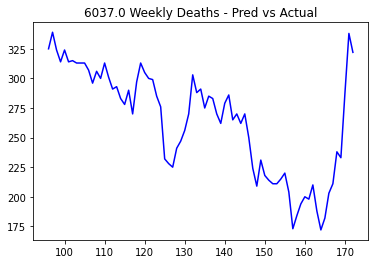

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
FIPS = [6037.0,  4013.0, 4019.0, 36059.0, 12086.0, 12011.0, 48201.0,48113.0,13121.0]

for f in FIPS:
    Deaths_Cases_df = US_Deaths_Cases_df[(US_Deaths_Cases_df["FIPS"] == f) & (US_Deaths_Cases_df["Days"] >= 96) & (US_Deaths_Cases_df["Days"] < 173)]
    predicted_df_90 = predicted_df_all_days[(predicted_df_all_days["FIPS"] == f) & (predicted_df_all_days["Days"] >= 96) & (predicted_df_all_days["Days"] < 173)]
 
    x = Deaths_Cases_df["Days"]
    z= predicted_df_90["Predicted_Weekly_Deaths"]
    y = Deaths_Cases_df["Weekly_Deaths"]
    plt.title(str(f) +" Weekly Deaths - Pred vs Actual")
    plt.plot(x, y, "-b", label="actual")
    plt.plot(x, z, "-r", label="predicted")
    plt.savefig(str(f) + "_Weekly_Deaths.png", dpi=100)   
    plt.show()
   
    x = Deaths_Cases_df["Days"]
    z= predicted_df_90["Predicted_Cumulative_Deaths"]
    y = Deaths_Cases_df["Cumulative_Deaths"]
    plt.title(str(f) +" Cumulative Deaths - Pred vs Actual")
    plt.plot(x, y, "-b", label="actual")
    plt.plot(x, z, "-r", label="predicted")
    plt.savefig(str(f) + "_X_Cumulative_Deaths.png", dpi=100)
    plt.show()
    

In [27]:
from datetime import datetime

covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")

state_predicted_deaths = predicted_df_all_days.groupby(['State', 'Days', 'Forecast_Day'], as_index=False)[["Predicted_Cumulative_Deaths"]].sum()
state_to_fips=pd.read_csv('https://docs.google.com/spreadsheets/d/1w4sHgYifJV-C8J1WV5rpTzEFLuyZ5ESp8r_1ck-9hlA/export?format=csv')
state_predicted_deaths = state_predicted_deaths.merge(state_to_fips, how='left', left_on=['State'], right_on=['Name'])
state_predicted_deaths=state_predicted_deaths.drop(columns=['Name'])
country_predicted_deaths = predicted_df_all_days.groupby(['Days', 'Forecast_Day'], as_index=False)[["Predicted_Cumulative_Deaths"]].sum()

state_predicted_deaths=state_predicted_deaths[['State','FIPS','Days','Forecast_Day','Predicted_Cumulative_Deaths']]
iteration = 0  
forecast_dates = country_predicted_deaths["Forecast_Day"].unique()
for forecast_date in forecast_dates:
  print(forecast_date)  
  covid_hub_predicted_deaths = pd.DataFrame(columns=['forecast_date','target', 'target_end_date','location', 'location_name','type', 'quantile', 'value']) 
  filename = "forecast-hub/data-processed/MIT_Sak/{}-MIT-Sak.csv".format(forecast_date)
  cp_detahs_forecast= country_predicted_deaths[country_predicted_deaths["Forecast_Day"] == forecast_date]
  for index, row in cp_detahs_forecast.iterrows():

      covid_hub_predicted_deaths.loc[iteration,"location"] = 'US'
      covid_hub_predicted_deaths.loc[iteration,"location_name"] = 'US'
      #predicted_df["FIPS"] = predict_week_df["FIPS"]
      #predicted_df["Days"] = predict_week_df["Days"]
      target_date = (covid_start_date + timedelta(days=row["Days"]))
      forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
      days_from = str(row["Days"] - forecast_day)
      covid_hub_predicted_deaths.loc[iteration,"target"] = days_from + " day ahead cum death"
      covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
      covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
      covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
      covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
      if row["Predicted_Cumulative_Deaths"] >= 0:
        covid_hub_predicted_deaths.loc[iteration,"value"] = row["Predicted_Cumulative_Deaths"]
      else:
        covid_hub_predicted_deaths.loc[iteration,"value"] = 0

      iteration = iteration + 1
  state_predicted_deaths_forecast = state_predicted_deaths[state_predicted_deaths["Forecast_Day"] == forecast_date]
  for index, row in state_predicted_deaths_forecast.iterrows():
      covid_hub_predicted_deaths.loc[iteration,"location"] = str(row["FIPS"]).zfill(2)
      covid_hub_predicted_deaths.loc[iteration,"location_name"] = row["State"]
   
      target_date = (covid_start_date + timedelta(days=row["Days"]))
      forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
      days_from = str(row["Days"] - forecast_day)
   
      covid_hub_predicted_deaths.loc[iteration,"target"] = days_from + " day ahead cum death"
      covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
      covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
      covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
      covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
      if row["Predicted_Cumulative_Deaths"] >= 0:
        covid_hub_predicted_deaths.loc[iteration,"value"] = row["Predicted_Cumulative_Deaths"]
      else:
        covid_hub_predicted_deaths.loc[iteration,"value"] = 0
      iteration = iteration + 1
  
  covid_hub_predicted_deaths.to_csv(filename,index = False)
  #files.download(filename)


2020-04-12
2020-04-19
2020-04-26
2020-05-03
2020-05-10
2020-05-17
2020-05-24
2020-05-31
2020-06-07
2020-06-14
2020-06-21
2020-06-28
2020-07-05
2020-07-12


In [29]:
import evaluate_models
from datetime import datetime, timedelta
from os import listdir
from os.path import isfile, join
files = listdir('forecast-hub/data-processed/MIT_Sak')
files.sort()
for f in files :
    if f!= '.DS_Store':
        proj_date = datetime.strptime(f[:10],"%Y-%m-%d").date() +  timedelta(days=1) #Monday
        eval_date = proj_date +  timedelta(days=5) #Saturday

        print("running evaluation for proj_date: ", proj_date, " eval_date: " , eval_date)
        evaluate_models.run_evaluation('forecast-hub',proj_date, eval_date, "eval/one-week")


running evaluation for proj_date:  2020-03-30  eval_date:  2020-04-04
Forecast hub dir: forecast-hub
proj_date: 2020-03-30
eval_date: 2020-04-04
out_dir   : eval/one-week
use_point: True
use_cumulative_deaths: False
Days ahead: 5
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auquan-SEIR.csv', '2020-05-24-Auquan-SEIR.csv', '2020-05-31-Auquan-SEIR.csv', '2020-06-07-Auquan-SEIR.csv', '2020-06-15-Auquan-SEIR.csv', '2020-06-21-Auquan-SEIR.csv', '2020-06-28-Auquan-SEIR.csv', '2020-07-05-Auquan-SEIR.csv']
CDDEP-SEIR - No files within range: ['2020-07-05-CDDEP-SEIR.csv']
COVIDhub-baseline - No files within range: ['2020-04-06-COVIDhub-baseline.csv', '2020-04-13-COVIDhub-baseline.csv', '2020-04-20-COVIDhub-baseline.csv', '2020-04-27-COVIDhub-baseline.csv', '2020-05-04-COVIDhub-baseline.csv', '2020-05-11-COVIDhub-baseline.csv', '2020-05-18-COVIDhub-baseline.csv', '2020-05-25-COVIDhub-baseline.csv', '2020-06-01-COVIDhub-baseline.csv', '2020-06-08

Saved to: eval/one-week/2020-04-04/projections_2020-03-30_2020-04-04.csv
------------------------
State-by-state mean absolute errors:
               Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  Kentucky  \
Baseline         -25.4    -1.3    -22.1      -2.9       -84.4     -43.9       -108.7      -2.9                 -13.4   -102.1    -73.9    -3.0   -0.7    -129.1    -61.7  -6.6    -9.7     -25.9   
Baseline_0.98    -25.8    -1.4    -22.8      -3.1       -88.4     -45.6       -109.8      -3.1                 -13.6   -103.9    -76.2    -3.0   -0.9    -131.5    -62.8  -6.7    -9.9     -26.1   
IHME-CurveFit     -2.5     1.9      0.4       9.9        31.4       9.4        -88.6      -0.1                   7.2    -48.2    -14.9    -1.9    4.0     -31.2    -34.0  28.2     0.8     -17.6   
MIT_Sak           65.7    25.5      5.9      64.6      2123.9      41.2       -10

Max projection date: 2020-05-30 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 17.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-11 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
Imperial-ensemble2
Max projection date: 2020-04-11 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
LANL-GrowthRate
Max projection date: 2020-05-23 - 6.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 51
-----------------------------
MIT_Sak
Max projection date: 2020-04-19 - 1.9 weeks ahead
* No median data
Num unique locations (pre-filt) : 50
Num unique locations (post-filt): 

Saved to: eval/one-week/2020-04-11/projections_2020-04-06_2020-04-11.csv
------------------------
State-by-state mean absolute errors:
                   Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  Kentucky  \
Baseline             -17.0     1.4    -12.7      -0.4       -64.0     -54.3       -172.1     -12.1                 -10.4    -75.6   -105.7    -0.6  -10.7    -224.7   -121.6  -4.0   -20.1     -14.1   
Baseline_0.98        -18.5     1.3    -14.7      -0.8       -73.3     -58.2       -178.6     -12.5                 -11.1    -82.5   -111.2    -0.7  -10.9    -233.4   -125.5  -4.6   -20.8     -15.6   
COVIDhub-baseline     -8.0     0.0    -28.0      -2.0      -136.0     -83.0       -197.0     -10.0                  -9.0   -102.0    -96.0    -2.0   -9.0    -236.0   -129.0  -9.0   -17.0     -19.0   
IHME-CurveFit        106.9    97.5     -4.8      19.6        55.5

Max projection date: 2020-06-06 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 16.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-18 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1


                      count     mean  median       std  min   25%     75%        max
Baseline               51.0  10722.6   196.0   35862.8  0.0   8.6  2709.2   241782.9
Baseline_0.98          51.0  12096.2   219.5   44242.2  0.1  14.4  3148.4   304169.0
MIT_Sak                51.0  25597.7  3777.3  120796.9 44.3 431.8  9078.9   863376.5
CU-select              51.0 550448.1  2916.0 3325568.3  1.0 270.2 32412.5 23726641.0
LANL-GrowthRate        51.0 569228.5   179.1 3975836.2  0.2  22.9  1804.2 28404348.0
COVIDhub-ensemble      51.0 653439.9   175.4 4595959.6  0.0  10.5  1727.9 32830768.3
COVIDhub-baseline      51.0 708354.4   225.0 4975927.2  1.0  16.0  3540.5 35545444.0
IHME-CurveFit          51.0 748181.7   310.0 5260377.8  0.2  55.0  4241.9 37577574.3
YYG-ParamSearch        51.0 750844.8   166.5 5277102.7  0.2  11.4  2166.3 37695584.3
MOBS_NEU-GLEAM_COVID   51.0 777952.8  3619.2 3943412.1  0.1 263.4 45236.5 26553201.4
Saved to: eval/one-week/2020-04-18/2020-04-13_2020-04-18_states_s

Max projection date: 2020-06-13 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-30 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-04-25 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 15.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-25 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (

                      count     mean  median       std  min   25%     75%        max
Baseline_0.98          51.0  17385.8   209.9   86923.9  0.0  21.1  2229.8   616563.3
YYG-ParamSearch        51.0  22383.2   244.3   93198.8  0.0  15.8  3065.1   591097.5
Baseline               51.0  24417.8   158.0  139866.2  0.0  18.0  1681.4   999428.7
IHME-CurveFit          51.0  24552.2   283.5  132873.5  0.0  46.7  2296.7   949137.7
MIT_Sak                51.0  48568.7  4170.8  136224.9  7.0 859.0 16505.9   738967.8
LANL-GrowthRate        51.0  85388.6   279.3  520177.3  0.5  54.9  2690.9  3715748.9
MOBS_NEU-GLEAM_COVID   51.0 202992.4  2444.0  666321.0  7.0 321.8 35665.9  3840962.9
CU-select              51.0 222566.6  1156.0 1118336.0  1.0 110.5 12100.5  7678441.0
COVIDhub-baseline      51.0 449020.7   100.0 3127744.2  0.0  25.0  1226.0 22344529.0
UT-Mobility            51.0 672410.2   313.8 4671909.9  0.7  19.1  2666.2 33377030.2
Saved to: eval/one-week/2020-04-25/2020-04-20_2020-04-25_states_s

Max projection date: 2020-06-20 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-02 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 14.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 53
Num unique locations (

UT-Mobility                 51.0 742192.2   140.6 5150666.1  0.2  19.6  2267.8 36793756.3
Saved to: eval/one-week/2020-05-02/2020-04-27_2020-05-02_states_sq_errs.csv
----------------------
States - mean absolute errors:
                           count  mean  median   std  min  25%   75%    max
COVIDhub-baseline           51.0  47.9    14.0 106.0  0.0  3.5  43.5  695.0
YYG-ParamSearch             51.0  52.0    10.5 111.9  0.1  2.9  34.8  525.9
Baseline_0.98               51.0  56.2     9.9 133.5  0.0  3.7  39.0  712.4
Baseline                    51.0  59.0    10.7 144.8  0.0  3.4  55.7  866.3
LANL-GrowthRate             51.0  86.5    13.9 193.3  0.1  4.0  69.8 1129.6
MIT_CovidAnalytics-DELPHI   51.0  88.2    28.0 326.6  0.0  5.0  59.0 2338.0
COVIDhub-ensemble           51.0  88.9    16.9 346.8  0.4  3.1  50.5 2465.4
MOBS_NEU-GLEAM_COVID        51.0 101.7    26.9 174.2  0.4  3.7  89.5  849.0
IHME-CurveFit               51.0 102.4    19.9 232.3  0.3  6.5  60.4 1164.0
IowaStateLW-STEM    

Max projection date: 2020-06-27 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-30 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-select
Max projection date: 2020-06-13 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
GT-DeepCOVID
Max projection date: 2020-05-18 - 2.0 weeks ahead
Num unique locations (pre-filt) : 48
Num unique locations (post-filt): 48
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-09 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-24 - 16.0 weeks ahead
* No median data
Num unique locations (pre-

Incident US deaths: 9037
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-07-04 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-06 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-20 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-05-23 - 1.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-08 - 4.0 weeks ahead
N

Saved to: eval/one-week/2020-05-16/projections_2020-05-11_2020-05-16.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                      -3.7     0.9      6.1       5.9       -63.4    -110.4         83.1     -27.3                   9.7     50.1     -1.7     0.0   -3.4     -47.6     89.3 -11.6     4.7   
Baseline_0.98                 -8.0     0.8     -1.1       5.2       -84.3    -115.8         61.0     -29.1                   6.7     35.9    -11.0     0.0   -3.6     -80.5     73.6 -15.0     3.5   
COVIDhub-baseline              7.0     1.0     55.0       6.0       -14.0     -90.0         89.0     -12.0                   7.0    102.0     31.0     1.0   -3.0      10.0    124.0 -17.0    11.0   
COVIDhub-ensemble            -14.9     1.7    -34.5       7.4       -44.0

Max projection date: 2020-07-11 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-13 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-15 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-15 - 4.0 weeks ahead
Num unique locations (pre-filt) : 26
Num unique locations (post-filt): 26
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-23 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IHME-CurveFit
Ma

Saved to: eval/one-week/2020-05-23/projections_2020-05-18_2020-05-23.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  110.0     2.0     43.0      24.0       283.0     120.0         62.0      44.0                  41.0    164.0     97.0     4.0   13.0     602.0    214.0  48.0    56.0   
Baseline                      20.4     0.0      2.4     -11.0       -47.9      97.1        111.0      27.1                   7.4    -44.0    -37.1     0.0   -0.9      47.9     -4.7 -21.3     8.0   
Baseline_0.98                 16.5     0.0     -3.6     -11.3       -69.7      87.0         92.6      24.3                   4.9    -54.5    -45.7     0.0   -1.1      15.7    -14.9 -24.9     7.1   
COVIDhub-baseline             31.0     0.0     25.0      -7.0        -8.0

Max projection date: 2020-07-18 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-20 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-10 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 38
Num unique locations (post-filt): 31
-----------------------------
Geneva-DetGrowth
Max proje

Saved to: eval/one-week/2020-05-30/projections_2020-05-25_2020-05-30.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana   Iowa  Kansas  \
Auquan-SEIR                  185.0     5.0    102.0      37.0       607.0     230.0        154.0      81.0                  78.0    325.0    170.0     8.0   24.0    1100.0    383.0   94.0    95.0   
Baseline                     -13.0     0.0      0.7      -1.6        49.6     -10.7         25.3      -4.1                  12.0     16.3      9.0     0.0    2.1     108.0     43.9   15.0    -1.4   
Baseline_0.98                -15.6     0.0     -4.3      -2.3        28.1     -15.6         13.4      -5.6                  10.0      5.3     -0.1     0.0    1.9      79.7     34.5   10.6    -1.8   
COVIDhub-baseline             -5.0     0.0     19.0      -1.0       1

Saved to: eval/one-week/2020-05-30/2020-05-25_2020-05-30_states_abs_errs.csv
----------------------
Mean/median ranks:
UMass-MechBayes              6.0
YYG-ParamSearch              6.3
LANL-GrowthRate              6.6
COVIDhub-ensemble            7.1
COVIDhub-baseline            7.7
MOBS_NEU-GLEAM_COVID         7.7
UCLA-SuEIR                   7.8
MIT_CovidAnalytics-DELPHI    7.8
UT-Mobility                  8.0
CU-select                    9.4
USACE-ERDC_SEIR              9.6
PSI-DRAFT                   10.9
IowaStateLW-STEM            11.3
UA-EpiCovDA                 11.7
Covid19Sim-Simulator        12.1
JHU_IDD-CovidSP             12.2
MIT_Sak                     12.3
Auquan-SEIR                 16.5
Name: mean_rank, dtype: float64
Saved to: eval/one-week/2020-05-30/2020-05-25_2020-05-30_states_mean_ranks.csv
running evaluation for proj_date:  2020-06-01  eval_date:  2020-06-06
Forecast hub dir: forecast-hub
proj_date: 2020-06-01
eval_date: 2020-06-06
out_dir   : eval/one-week
use_p

Max projection date: 2020-08-08 - 9.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-06-06 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
Imperial-ensemble2
Max projection date: 2020-06-06 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IowaStateLW-STEM
Max projection date: 2020-10-03 - 17.7 weeks ahead
Num unique locations (pre-filt) : 50
Num unique locations (post-filt): 50
-----------------------------
JHU_IDD-CovidSP
Max projection date: 2020-06-27 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
LANL-GrowthRate
Max projection date: 2020-07-18 - 6.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
----------------------

Saved to: eval/one-week/2020-06-06/projections_2020-06-01_2020-06-06.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  124.0     5.0    125.0      47.0       682.0     331.0        419.0      95.0                  99.0    313.0    270.0     8.0   33.0    1086.0    267.0 139.0    94.0   
Baseline                       8.7     0.0    -45.1      -6.4       -75.9      14.9        104.1      10.3                  12.1    -53.6     68.7     0.0    1.6     -16.3    -22.6   3.7    -9.4   
Baseline_0.98                  5.4     0.0    -49.6      -7.1       -93.3      10.1         93.7       8.6                  10.7    -62.5     59.3     0.0    1.4     -38.6    -29.2   0.4    -9.8   
COVIDhub-baseline             -2.0     0.0    -36.0      -3.0       -56.0

Max projection date: 2020-08-01 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-06 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-24 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
------

Saved to: eval/one-week/2020-06-13/projections_2020-06-08_2020-06-13.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  133.0     2.0    193.0      70.0       839.0     231.0        344.0      73.0                  60.0    697.0    355.0     5.0   20.0    1028.0    290.0 305.0    71.0   
Baseline                     -27.9    -2.0    -14.6      -5.0       -49.7       0.3         -6.1       6.4                  -2.3    -11.6   -158.1     0.0   -3.1      55.6     34.9  15.0     3.4   
Baseline_0.98                -30.4    -2.0    -20.6      -5.9       -68.9      -3.1        -11.4       5.1                  -3.2    -22.0   -163.4     0.0   -3.2      34.1     27.8  12.1     2.7   
COVIDhub-baseline            -13.0    -2.0     -7.0      -2.0        -8.0

Max projection date: 2020-08-08 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-11 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-13 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-31 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-07-11 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
------

------------------------
Cumulative death forecasts for 2020-06-20:
                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Covid19Sim-Simulator  CovidActNow-SEIR_CAN  GT-DeepCOVID  GT_CHHS-COVID19  \
Alabama                       838.0     842.4          839.0       1059.0              857.0              859.1      906.0                 870.3                 838.2           nan              nan   
Alaska                         12.0      13.7           13.6         17.0               14.0               13.0       12.0                  12.0                  14.9          13.6              nan   
Arizona                      1346.0    1311.0         1305.2       1788.0             1335.0             1386.1     1476.0                1521.6                1387.1           nan              nan   
Arkansas                      224.0     200.4          199.4        314.0              200.0              206.2      217.0      

Incident US deaths: 5516
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-15 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-20 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-11-07 - 19.7 we

Saved to: eval/one-week/2020-06-27/projections_2020-06-22_2020-06-27.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                   -7.0    -1.0     15.0       7.0       188.0      34.0         44.0     -51.0                   4.0     84.0    176.0     0.0    6.0     178.0     36.0  33.0    13.0   
Baseline                     -23.4    -2.0    -95.6       5.4       -27.4      15.0         -0.4     -60.9                   0.4    -31.9     31.6    -1.0   -0.3      64.6     25.1  11.1    -0.7   
Baseline_0.98                -26.2    -2.0   -102.2       3.5       -44.8      13.0         -2.9     -61.4                  -0.3    -41.5     23.6    -1.0   -0.4      50.4     20.2   9.7    -1.2   
COVIDhub-baseline            -16.0    -2.0    -77.0      12.0        13.0

----------------------------------
Past truth file: /Users/snathikudi/work/covid-forecaster/truth/truth-cumulative-deaths-2020-06-29.csv
Incident US deaths: 3329
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-07-25 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-22 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-25 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-27 - 4.0 weeks ahead
Num unique locations (pre-fil

Saved to: eval/one-week/2020-07-04/projections_2020-06-29_2020-07-04.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                   -9.0    -1.0     50.0      39.0       168.0      36.0         64.0      21.0                  12.0    117.0    134.0     0.0    9.0     194.0     40.0  41.0    13.0   
Baseline                     -19.4    -0.3    -13.0      11.4       -44.6      -0.1         29.0      56.7                   7.6    -61.9     36.7    -0.1   -0.3      80.6     -0.3   2.1    -3.7   
Baseline_0.98                -22.8    -0.4    -23.2       9.8       -62.0      -1.4         26.7      53.7                   6.9    -72.6     31.1    -0.2   -0.4      70.5     -3.6   1.3    -4.2   
COVIDhub-baseline             -7.0     0.0     -3.0       8.0       -30.0

Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CDDEP-SEIR
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 24
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-08-01 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-08-15 - 5.7 weeks a

                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Columbia_UNC-SurvCon  Covid19Sim-Simulator  CovidActNow-SEIR_CAN  \
Alabama                      1114.0    1082.4         1078.8       1127.0             1095.0             1101.8     1208.0                   nan                1086.8                1178.2   
Alaska                         17.0      17.7           17.6         18.0               18.0               17.6       16.0                   nan                  16.2                  35.7   
Arizona                      2151.0    2023.0         2013.4       2279.0             2054.0             2072.6     2288.0                   nan                2247.3                2590.4   
Arkansas                      319.0     306.7          305.8        336.0              313.0              320.7      336.0                   nan                 306.3                 369.2   
California                   7027.0    6

MOBS_NEU-GLEAM_COVID - No files within range: ['2020-04-13-MOBS_NEU-GLEAM_COVID.csv', '2020-04-20-MOBS_NEU-GLEAM_COVID.csv', '2020-04-27-MOBS_NEU-GLEAM_COVID.csv', '2020-05-04-MOBS_NEU-GLEAM_COVID.csv', '2020-05-11-MOBS_NEU-GLEAM_COVID.csv', '2020-05-18-MOBS_NEU-GLEAM_COVID.csv', '2020-05-25-MOBS_NEU-GLEAM_COVID.csv', '2020-06-01-MOBS_NEU-GLEAM_COVID.csv', '2020-06-08-MOBS_NEU-GLEAM_COVID.csv', '2020-06-15-MOBS_NEU-GLEAM_COVID.csv', '2020-06-22-MOBS_NEU-GLEAM_COVID.csv', '2020-06-29-MOBS_NEU-GLEAM_COVID.csv', '2020-07-06-MOBS_NEU-GLEAM_COVID.csv']
NotreDame-FRED - No files within range: ['2020-05-04-NotreDame-FRED.csv', '2020-05-11-NotreDame-FRED.csv', '2020-05-18-NotreDame-FRED.csv', '2020-05-25-NotreDame-FRED.csv', '2020-06-01-NotreDame-FRED.csv', '2020-06-08-NotreDame-FRED.csv', '2020-06-15-NotreDame-FRED.csv', '2020-06-22-NotreDame-FRED.csv', '2020-06-29-NotreDame-FRED.csv', '2020-07-06-NotreDame-FRED.csv']
NotreDame-mobility - No files within range: ['2020-06-22-NotreDame-mobility

KeyError: 'US'

In [30]:

for f in files :
    if f!= '.DS_Store':
        proj_date = datetime.strptime(f[:10],"%Y-%m-%d").date() +  timedelta(days=1) #Monday
        eval_date = proj_date +  timedelta(days=12) #Saturday

        print("running evaluation for proj_date: ", proj_date, " eval_date: " , eval_date)
        evaluate_models.run_evaluation('forecast-hub',proj_date, eval_date, "eval/two-weeks")

running evaluation for proj_date:  2020-03-30  eval_date:  2020-04-11
Forecast hub dir: forecast-hub
proj_date: 2020-03-30
eval_date: 2020-04-11
out_dir   : eval/two-weeks
use_point: True
use_cumulative_deaths: False
Days ahead: 12
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auquan-SEIR.csv', '2020-05-24-Auquan-SEIR.csv', '2020-05-31-Auquan-SEIR.csv', '2020-06-07-Auquan-SEIR.csv', '2020-06-15-Auquan-SEIR.csv', '2020-06-21-Auquan-SEIR.csv', '2020-06-28-Auquan-SEIR.csv', '2020-07-05-Auquan-SEIR.csv']
CDDEP-SEIR - No files within range: ['2020-07-05-CDDEP-SEIR.csv']
COVIDhub-baseline - No files within range: ['2020-04-06-COVIDhub-baseline.csv', '2020-04-13-COVIDhub-baseline.csv', '2020-04-20-COVIDhub-baseline.csv', '2020-04-27-COVIDhub-baseline.csv', '2020-05-04-COVIDhub-baseline.csv', '2020-05-11-COVIDhub-baseline.csv', '2020-05-18-COVIDhub-baseline.csv', '2020-05-25-COVIDhub-baseline.csv', '2020-06-01-COVIDhub-baseline.csv', '2020-06-

Saved to: eval/two-weeks/2020-04-11/2020-03-30_2020-04-11_states_sq_errs.csv
----------------------
States - mean absolute errors:
               count  mean  median    std  min  25%   75%    max
IHME-CurveFit   51.0 155.3    44.9  546.7  0.9 12.7  97.1 3818.0
Baseline        51.0 309.1    62.9 1074.8  0.0 13.7 178.1 7533.1
Baseline_0.98   51.0 320.8    65.5 1124.0  0.0 14.0 182.0 7891.8
Saved to: eval/two-weeks/2020-04-11/2020-03-30_2020-04-11_states_abs_errs.csv
----------------------
Mean/median ranks:
IHME-CurveFit   1.0
Name: mean_rank, dtype: float64
Saved to: eval/two-weeks/2020-04-11/2020-03-30_2020-04-11_states_mean_ranks.csv
running evaluation for proj_date:  2020-04-06  eval_date:  2020-04-18
Forecast hub dir: forecast-hub
proj_date: 2020-04-06
eval_date: 2020-04-18
out_dir   : eval/two-weeks
use_point: True
use_cumulative_deaths: False
Days ahead: 12
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auquan-SEIR.csv', '2020-05-2

Max projection date: 2020-05-30 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 17.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-11 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
Imperial-ensemble2
Max projection date: 2020-04-11 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
LANL-GrowthRate
Max projection date: 2020-05-23 - 6.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 51
-----------------------------
MIT_Sak
Max proj

------------------------
State-by-state mean absolute errors:
                   Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  Kentucky  \
Baseline             -43.0     4.4    -28.7      -3.4      -376.0     -98.3       -609.1     -38.1                 -37.4   -220.6   -218.7     2.4  -23.7    -598.7   -241.6 -30.0   -35.1     -32.1   
Baseline_0.98        -50.3     3.6    -38.5      -5.5      -422.4    -117.6       -641.3     -39.8                 -41.0   -254.8   -245.9     1.6  -24.8    -641.8   -261.3 -32.9   -38.3     -39.6   
COVIDhub-baseline    -29.0     2.0    -54.0      -6.0      -493.0    -140.0       -657.0     -35.0                 -36.0   -271.0   -208.0     0.0  -21.0    -621.0   -259.0 -38.0   -30.0     -42.0   
IHME-CurveFit        289.4   182.3     31.4      57.1       -36.8    -149.5        553.7     -20.7                 -47.6   1196.9    704.3

Max projection date: 2020-06-06 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 16.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-18 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num

                      count      mean  median       std  min    25%     75%        max
MIT_Sak                51.0   32824.1  6097.5   83172.9  8.0  464.1 21308.1   513244.8
CU-select              51.0  161421.6  8100.0  423298.8  9.0 2120.0 57962.0  2601769.0
Baseline_0.98          51.0  185783.5  1793.8  732275.4  0.9   89.8 22251.4  4946111.0
Baseline               51.0  316226.9  1205.1 1819768.3  0.3   79.2 15898.2 12988816.0
LANL-GrowthRate        51.0  414567.2  1415.2 2583676.1  0.0   80.2  9365.4 18476744.4
COVIDhub-baseline      51.0  545282.5  1369.0 3359997.2  1.0   90.5 15542.5 24010000.0
COVIDhub-ensemble      51.0  794572.3  1188.5 5227557.3  0.1  134.0 22410.6 37360506.9
YYG-ParamSearch        51.0 1022708.5  1362.8 6711687.3  6.2  131.7 20480.3 47962784.5
MOBS_NEU-GLEAM_COVID   51.0 1286464.1  8058.9 5754202.3  0.4  412.0 40895.3 34963815.0
IHME-CurveFit          51.0 1346056.1  1917.5 8789363.6  0.0  295.2 72770.5 62824487.9
Saved to: eval/two-weeks/2020-04-25/2020-04

Max projection date: 2020-06-13 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-30 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-04-25 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 15.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-25 - 0.7 weeks ahead
* No point

                      count      mean  median        std  min    25%     75%         max
YYG-ParamSearch        51.0   55811.2  1013.9   195834.8  0.3   36.4 15930.6   1318613.4
IHME-CurveFit          51.0  117048.3  1725.7   412365.7  0.8   97.9 24109.2   2733734.9
Baseline_0.98          51.0  130988.0   991.2   788341.5  0.4  133.3 11327.1   5636721.1
CU-select              51.0  180684.3  5329.0   570674.2  1.0  210.5 35770.0   3594816.0
MIT_Sak                51.0  183586.7 11146.1   519084.9  0.3 2210.1 38067.3   2667691.0
Baseline               51.0  245096.0   388.7  1655219.4  1.7  124.2  6669.8  11831634.4
LANL-GrowthRate        51.0  502847.0  1536.8  3279210.9  0.3  103.3 11752.0  23438365.4
MOBS_NEU-GLEAM_COVID   51.0  553833.7  8503.5  1963947.5  0.8 1409.5 64975.1  11430422.2
UT-Mobility            51.0 1254990.3   987.8  8081118.9  0.2  150.9 26564.3  57653649.0
COVIDhub-baseline      51.0 2437393.4   360.6 17158589.0  1.0   82.0  9434.0 122567041.0
Saved to: eval/two-we

Max projection date: 2020-06-20 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-02 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 14.1 weeks ahead
* No median data
Num unique 

Saved to: eval/two-weeks/2020-05-09/projections_2020-04-27_2020-05-09.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                     -55.9    -1.0    -88.0     -14.7        55.7     218.7        472.1      -2.6                  19.3    -81.0    -61.7     4.4   11.3    -221.9   -210.9 -54.1    -1.0   
Baseline_0.98                -68.7    -1.0   -106.9     -17.2       -57.9     163.2        306.9     -13.6                   2.3   -143.4   -109.2     3.6    8.8    -355.2   -262.9 -63.1    -6.8   
COVIDhub-baseline            -69.0    -0.8    -73.0     -20.0       100.0     307.0        491.0     -19.0                   2.0    -46.0    -28.0     4.0   15.0    -242.0   -222.0 -64.0    16.0   
COVIDhub-ensemble            -34.8     3.2    -71.9       9.3       141.

Max projection date: 2020-06-27 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-30 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-select
Max projection date: 2020-06-13 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
GT-DeepCOVID
Max projection date: 2020-05-18 - 2.0 weeks ahead
Num unique locations (pre-filt) : 48
Num unique locations (post-filt): 48
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-09 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-24 - 16.0 weeks a

                           count  mean  median    std  min  25%   75%    max
COVIDhub-ensemble           51.0  50.4    19.7   80.1  0.0  5.8  64.2  421.9
YYG-ParamSearch             51.0  71.3    32.0  110.4  0.7  8.7  78.6  547.0
Baseline_0.98               51.0  82.6    24.8  156.7  0.0  5.8  71.7  799.1
LANL-GrowthRate             51.0  86.9    32.2  161.0  0.1  8.6 112.4 1028.3
COVIDhub-baseline           51.0  91.2    22.0  209.2  0.0  7.5  46.0 1137.0
Baseline                    51.0  93.2    18.4  240.3  0.0  6.2  60.9 1199.9
CU-select                   51.0  94.8    39.0  156.6  0.0 11.0 121.5  955.0
UMass-MechBayes             51.0 128.8    46.0  267.9  0.0  9.0 125.0 1667.0
IHME-CurveFit               51.0 146.1    28.9  292.4  0.6  8.5 124.0 1387.7
MOBS_NEU-GLEAM_COVID        51.0 163.2    49.8  262.7  0.5 14.2 167.1 1240.6
MIT_Sak                     51.0 165.1    60.4  377.5  2.3 25.9 152.6 2607.6
UCLA-SuEIR                  51.0 185.6    46.7  544.3  0.2 12.1 150.9 3798.6

Max projection date: 2020-07-04 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-06 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-20 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-05-23 - 1.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-08 - 4.0 weeks ahead
Num unique locations (pre-filt) : 28
Num unique locations (post-filt): 22
--------------------------

Saved to: eval/two-weeks/2020-05-23/projections_2020-05-11_2020-05-23.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana   Iowa  Kansas  \
Baseline                      35.3     1.9     58.1       3.9       -92.4    -116.4        278.1     -19.3                  29.7    123.1     -3.7     0.0   -6.4      79.4    242.3  -30.6    24.7   
Baseline_0.98                 13.9     1.6     22.1       0.7      -196.1    -143.2        168.1     -28.4                  14.8     52.2    -49.7     0.0   -7.1     -83.9    164.3  -47.4    18.5   
COVIDhub-baseline             45.0     2.0    135.0       5.0       -36.0     -90.0        249.0       5.0                  26.0    184.0     33.0     2.3   -5.9     139.0    276.0  -40.0    33.0   
COVIDhub-ensemble             11.7     2.1    -25.8       6.8      -

Max projection date: 2020-07-11 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-13 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-15 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-15 - 4.0 weeks ahead
Num unique locations (pre-filt) : 26
Num unique locations (post-filt): 26
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-23 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping..

                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana   Iowa  Kansas  \
Auquan-SEIR                  185.0     5.0    102.0      37.0       608.0     230.0        154.0      81.0                  78.0    325.0    170.0     8.0   24.0    1100.0    383.0   94.0    95.0   
Baseline                      46.4     0.0     43.4     -22.0        69.1     225.1        315.0      57.1                  32.4     -6.0    -15.1     0.0    2.1     278.9     77.3  -20.3    19.0   
Baseline_0.98                 26.7     0.0     13.6     -23.5       -39.5     174.6        223.6      42.8                  20.0    -58.2    -57.4     0.0    0.9     119.0     26.9  -38.1    14.6   
COVIDhub-baseline             57.0     0.0     69.0     -15.0       106.0     199.0        241.0      55.0                  41.0     15.0    -16.1     1.0    3.0     359.0    118.0    3.0    22.0   
COVID

Max projection date: 2020-07-18 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-20 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-10 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 38
Num unique locations (post-filt): 31
-----------------------------
Geneva-DetGrowth
Max proje

Saved to: eval/two-weeks/2020-06-06/projections_2020-05-25_2020-06-06.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana   Iowa  Kansas  \
Auquan-SEIR                  216.0     6.0     96.0      35.0       741.0     329.0        281.0     114.0                 108.0    379.0    168.0    10.0   32.0    1290.0    429.0  124.0   107.0   
Baseline                     -21.0     0.0    -17.3      -4.6       100.6      22.3        167.3       2.9                  40.0     39.3     52.0     0.0    7.1     253.0    101.9   52.0    -9.4   
Baseline_0.98                -34.1     0.0    -42.4      -8.3        -6.0      -2.0        108.2      -4.6                  29.8    -15.4      7.0     0.0    5.9     112.2     55.2   30.2   -11.5   
COVIDhub-baseline            -12.0     0.0      2.0      -5.0       

Max projection date: 2020-07-25 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-27 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-29 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-17 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-06-27 - 3.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
------

Saved to: eval/two-weeks/2020-06-13/projections_2020-06-01_2020-06-13.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  130.0     4.0     99.0      46.0       732.0     408.0        502.0     111.0                 115.0    301.0    179.0    10.0   38.0    1363.0    387.0 178.0   113.0   
Baseline                       3.7    -2.0    -85.1     -12.4      -125.9      57.9        224.1      21.3                  18.1    -76.6     25.7     0.0    0.6      92.7     14.4  31.7   -11.4   
Baseline_0.98                -12.7    -2.0   -107.1     -16.0      -212.7      34.4        172.1      13.0                  11.1   -120.9    -21.1     0.0   -0.1     -18.0    -18.3  15.3   -13.5   
COVIDhub-baseline            -17.1    -2.0    -79.0      -8.0      -117.

Max projection date: 2020-08-01 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-06 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-24 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
------

Saved to: eval/two-weeks/2020-06-20/projections_2020-06-08_2020-06-20.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  243.0     5.0    321.0     119.0      1768.0     403.0        620.0     143.0                 107.0   1547.0    618.0     9.0   37.0    1879.0    593.0 530.0   122.0   
Baseline                     -30.9    -2.0    -27.6     -31.0        -7.7      32.3         55.9      23.4                   0.7     18.4   -226.1     0.0   -4.1     233.6     80.9  54.0    10.4   
Baseline_0.98                -43.7    -2.0    -57.4     -35.4      -103.1      15.3         29.5      16.8                  -4.1    -33.2   -252.5     0.0   -4.4     127.0     45.8  39.5     6.7   
COVIDhub-baseline             -7.0    -2.0    -25.0     -28.0        36.

Max projection date: 2020-08-08 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-11 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-13 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-31 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-07-11 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
------

Saved to: eval/two-weeks/2020-06-27/projections_2020-06-15_2020-06-27.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  425.0     8.0    846.0     200.0      2128.0     370.0        591.0      88.0                 130.0   1347.0    826.0     9.0   45.0    2450.0    811.0 329.0   137.0   
Baseline                       4.4     1.7   -129.0     -33.6        67.3      55.9        131.4     -40.4                  15.3    -30.0    178.3    -1.0    3.4     185.3     27.0  35.3    -0.7   
Baseline_0.98                -12.4     1.3   -158.0     -38.8       -29.5      41.1        104.5     -45.4                   9.9    -77.9    122.1    -1.0    2.6     101.5      2.3  25.5    -3.2   
COVIDhub-baseline             22.0     2.0    -99.0     -36.0       117.

Max projection date: 2020-08-15 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-20 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-11-07 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 43
Num unique locations (post-filt): 43
------

Saved to: eval/two-weeks/2020-07-04/projections_2020-06-22_2020-07-04.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  -24.0    -1.0      6.0      25.0       224.0      52.0         91.0     -40.0                  10.0     63.0    323.0     0.0    9.0     335.0     74.0  54.0    15.0   
Baseline                     -45.4    -4.0   -174.6      24.4       -46.4      37.0         34.6     -52.9                   9.4   -113.9    142.6    -2.0   -0.3     262.6     72.1  28.1    -3.7   
Baseline_0.98                -59.1    -4.0   -207.3      14.9      -132.7      26.8         22.3     -55.6                   5.7   -161.5    102.8    -2.0   -0.7     192.3     47.7  21.1    -6.2   
COVIDhub-baseline            -39.0    -4.0   -157.0      32.0        -4.

Max projection date: 2020-08-22 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-25 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-27 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-11-14 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
GT-DeepCOVID
Max projection date: 2020-07-27 - 4.0 weeks ahead
Num unique locations (pre-filt) : 50
Num unique locations (post-filt): 41
--------------

Saved to: eval/two-weeks/2020-07-11/projections_2020-06-29_2020-07-11.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  -46.0     0.0    -11.0      59.0       -64.0      58.0        113.0      43.0                  15.0    -43.0    152.0     2.0    8.0      74.0     53.0  56.0    22.0   
Baseline                     -46.4     0.7   -102.0      17.4      -320.6       4.9         72.0     123.7                  13.6   -298.9     32.7     0.9   -7.3     -33.4      9.7  -4.9    -3.7   
Baseline_0.98                -63.0     0.3   -152.8       9.3      -407.0      -1.2         60.4     108.8                  10.0   -352.3      4.7     0.6   -7.7     -83.4     -6.7  -9.0    -6.2   
COVIDhub-baseline            -33.0     1.0   -103.0      10.0      -317.

KeyError: 'US'